## Tools

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Dataset

In [5]:
data = pd.read_csv("/Users/titolanna/Desktop/ml-assignment/breast_cancer_data.csv")
data.head(10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
5,12.45,15.70,82.57,477.1,0.12780,0
6,18.25,19.98,119.60,1040.0,0.09463,0
7,13.71,20.83,90.20,577.9,0.11890,0
8,13.00,21.82,87.50,519.8,0.12730,0
9,12.46,24.04,83.97,475.9,0.11860,0


## Basic EDA

<Axes: >

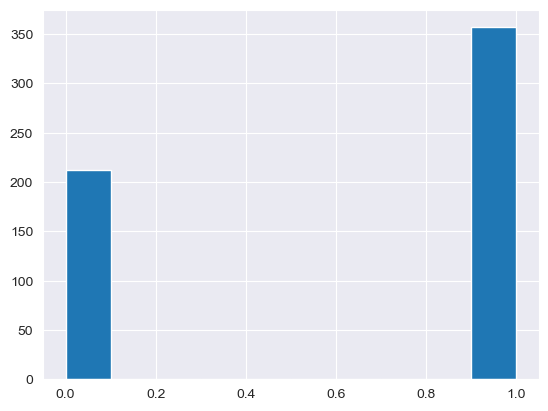

In [6]:
data["diagnosis"].hist()

<Axes: >

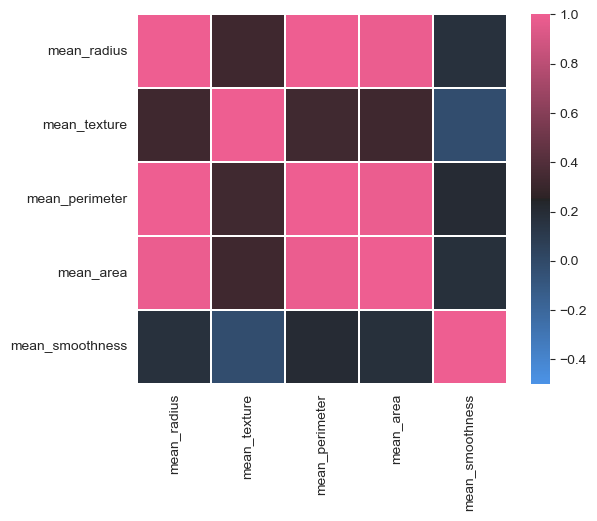

In [7]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [8]:
data = data[["mean_radius", "mean_texture", "mean_smoothness", "diagnosis"]]
data.head(10)

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
5,12.45,15.70,0.12780,0
6,18.25,19.98,0.09463,0
7,13.71,20.83,0.11890,0
8,13.00,21.82,0.12730,0
9,12.46,24.04,0.11860,0


<Axes: xlabel='mean_texture', ylabel='Count'>

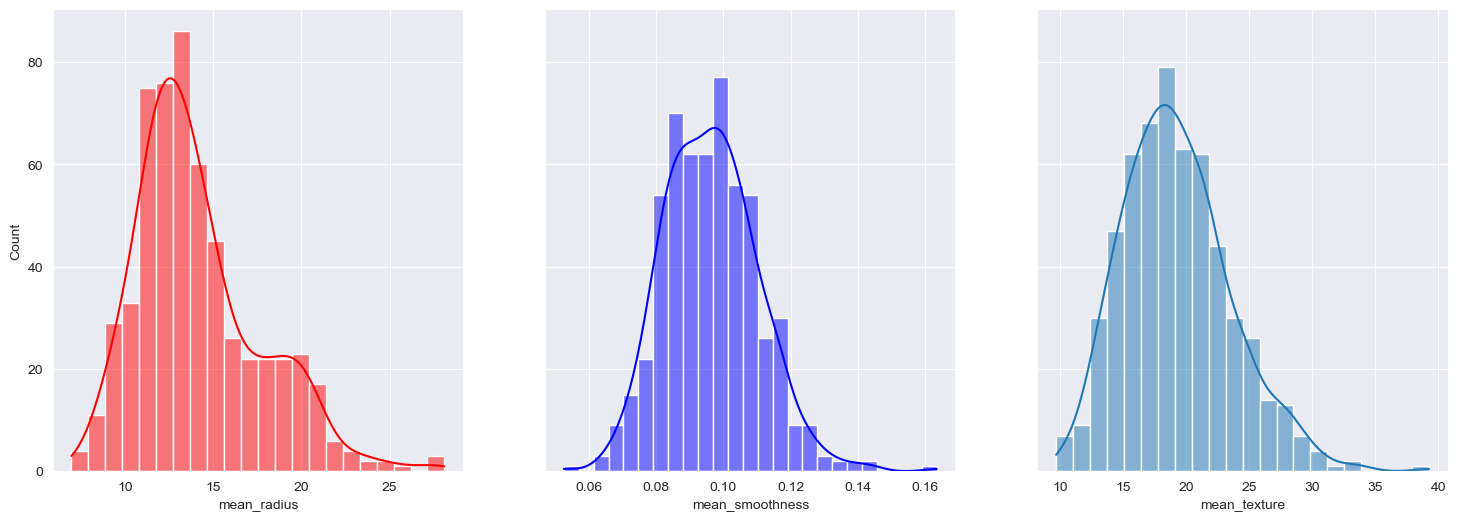

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="mean_texture", kde=True)


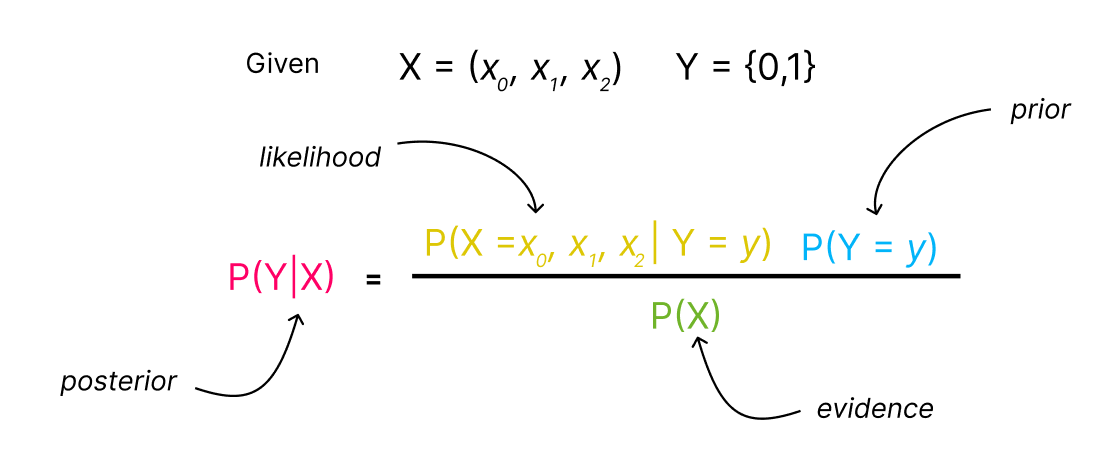

## Calculate P(Y=y) for all possible y

In [10]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

## Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [11]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [12]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

## Test Gaussian model

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 0 74]]
0.9736842105263158


#### Confusion Matrix

In [18]:
conf_mat = confusion_matrix(Y_test, Y_pred)
print(conf_mat)

[[38  2]
 [ 5 69]]


#### Visualizing The Confusion Matrix

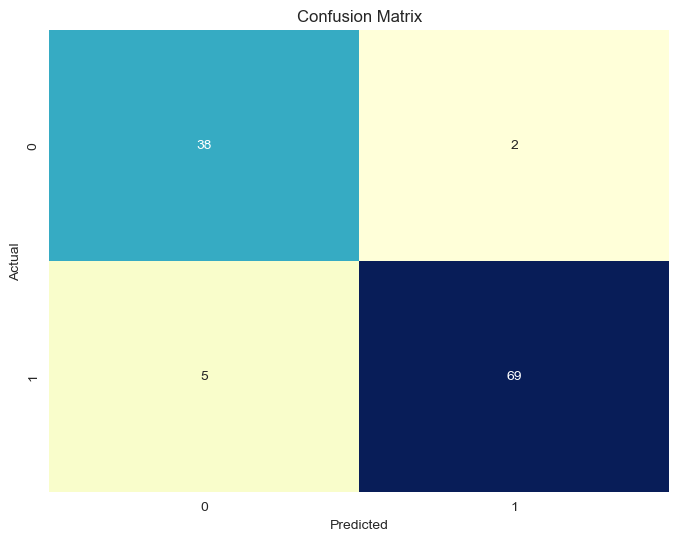

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='YlGnBu', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### what does means 0? false negative ... and what about 4? false positive

***Answer***
***True Negative (TN)***
the model classified the instance as negative, and it was indeed negative.


***False Positive (FP)***
the model classified the instance as positive, but it was actually negative.

***False Negative(FN)***
the model classified the instance as negative, but it was actually positive.

 ***True Positive (TP)***
This means that the model correctly predicted the positive class when the actual class was indeed positive.


#### Accuracy

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, log_loss

In [22]:
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9385964912280702


#### ROC curve

In [23]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)


Visualizing The Roc Curve

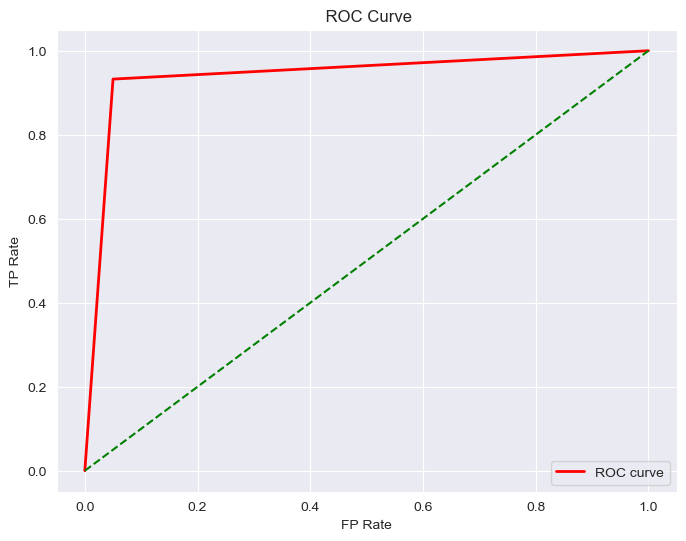

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title(' ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### Area Under the Curve

In [33]:
auc = roc_auc_score(Y_test, Y_pred)
print("Area Under the Curve:", auc)

Area Under the Curve: 0.9412162162162161


#### Log Loss

In [34]:
logloss = log_loss(Y_test, Y_pred)
print("Log Loss:", logloss)

Log Loss: 2.2132067870510532


## Convert continuous features to Categorical features

In [14]:
data["cat_mean_radius"] = pd.cut(data["mean_radius"].values, bins = 3, labels = [0,1,2])
data["cat_mean_texture"] = pd.cut(data["mean_texture"].values, bins = 3, labels = [0,1,2])
data["cat_mean_smoothness"] = pd.cut(data["mean_smoothness"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["mean_radius", "mean_texture", "mean_smoothness"])
data = data[["cat_mean_radius",	"cat_mean_texture",	"cat_mean_smoothness", "diagnosis"]]
data.head(10)

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0
5,0,0,2,0
6,1,1,1,0
7,0,1,1,0
8,0,1,2,0
9,0,1,1,0


## Approach 2: Calculate P(X=x|Y=y) categorically

In [15]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

## Naive Bayes Categorical Classifier

In [16]:
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

## Test Categorical model

In [44]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
sk_confMat=confusion_matrix(Y_test, Y_pred)
print(sk_confMat)


[[38  2]
 [ 5 69]]


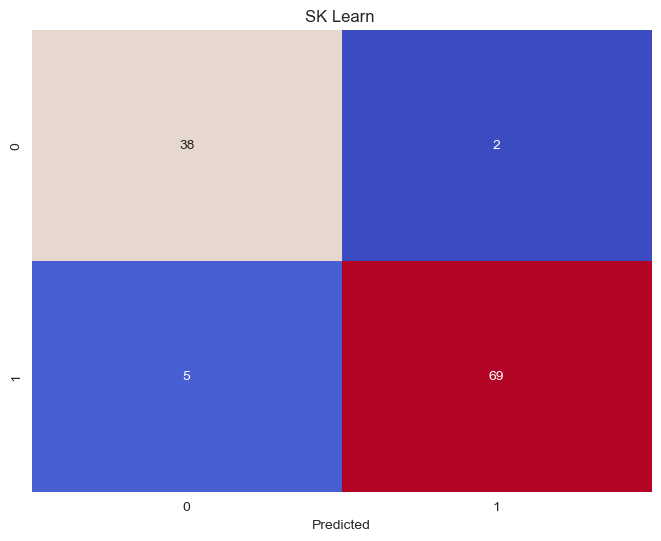

F1_ Score :  0.9517241379310345


In [48]:
plt.figure(figsize=(8, 6))
sns.heatmap(sk_confMat, annot=True, cmap='coolwarm', fmt='g', cbar=False)
plt.title('SK Learn ')
plt.xlabel('Predicted')
plt.show()

print("F1_ Score : " ,f1_score(Y_test, Y_pred))